모듈 호출 및 세팅

In [45]:
%pip install pandas numpy scikit-learn nltk matplotlib seaborn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVR
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, confusion_matrix, precision_recall_curve, auc

# NLTK 데이터 다운로드
nltk.download('stopwords')
nltk.download('wordnet')

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score

Note: you may need to restart the kernel to use updated packages.


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

데이터 호출 및 전처리

In [46]:
# 데이터셋 로드
file_path = './wine_review.csv'
df = pd.read_csv(file_path)

# 데이터셋 확인
print(df.head())

# 데이터 전처리
# 노이즈 제거 및 결측값 처리
df = df.dropna(subset=['reviews.text', 'reviews.rating'])

# 텍스트 토큰화 및 불용어 제거
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = re.sub(r'\W', ' ', str(text))
    tokens = text.split()
    tokens = [word.lower() for word in tokens if word.lower() not in stop_words]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

df['cleaned_reviews'] = df['reviews.text'].apply(preprocess_text)

# 전처리된 데이터를 새로운 CSV 파일로 저장
output_file_path = './cleaned_wine_review.csv'
df.to_csv(output_file_path, index=False)

print("전처리 완료 및 파일 저장:", output_file_path)

                     id asins            brand  \
0  AV13ClKCGV-KLJ3akN68   NaN            Gallo   
1  AV13CsvW-jtxr-f38AQO   NaN  Fresh Craft Co.   
2  AV13CVI_glJLPUi8O7Po   NaN     1000 Stories   
3  AV13CVI_glJLPUi8O7Po   NaN     1000 Stories   
4  AV13CYL4-jtxr-f37_-t   NaN     Wine Cube153   

                                          categories             dateAdded  \
0  Food & Beverage,Beverages,Wine, Beer & Liquor,...  2017-07-24T23:59:11Z   
1  Food & Beverage,Beverages,Wine, Beer & Liquor,...  2017-07-24T23:59:42Z   
2  Food & Beverage,Beverages,Wine, Beer & Liquor,...  2017-07-24T23:58:05Z   
3  Food & Beverage,Beverages,Wine, Beer & Liquor,...  2017-07-24T23:58:05Z   
4  Food & Beverage,Beverages,Wine, Beer & Liquor,...  2017-07-24T23:58:18Z   

            dateUpdated                                       descriptions  \
0  2018-01-10T18:06:28Z                                                NaN   
1  2018-01-10T05:38:33Z  [{"dateSeen":["2017-12-21T05:43:00.000Z","2017...

모델 생성 및 평가 (SVR모델 사용)

In [47]:
# 전처리된 데이터 로드
file_path = './cleaned_wine_review.csv'
df = pd.read_csv(file_path)

# 데이터셋 확인
print(df.head())

# 데이터 전처리: NaN 값 제거
df = df.dropna(subset=['cleaned_reviews', 'reviews.rating'])

# 감성 분석을 위한 데이터 준비
X = df['cleaned_reviews']
y = df['reviews.rating'].astype(float)

# 데이터셋을 학습용과 테스트용으로 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# TF-IDF 벡터화 및 SVR을 포함한 파이프라인 정의
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('svr', SVR())
])

# 그리드 서치를 위한 하이퍼파라미터 정의
param_grid = {
    'tfidf__max_df': [0.8, 0.9, 1.0],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'svr__C': [0.1, 1, 10],
    'svr__epsilon': [0.1, 0.2, 0.5]
}

# 그리드 서치 수행
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# 모델 평가
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

#SVR(회귀 모델)의 성능을 평가하기 위해 평균 제곱 오차 (MSE), 평균 절대 오차 (MAE), R² 점수 등의 지표를 사용
print("최적 하이퍼파라미터:", grid_search.best_params_)
print("평균 제곱 오차 (MSE):", mse)
print("평균 절대 오차 (MAE):", mae)
print("R² 점수:", r2)

# 교차 검증
cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
print("교차 검증 MSE:", -cv_scores.mean())

                     id asins            brand  \
0  AV13ClKCGV-KLJ3akN68   NaN            Gallo   
1  AV13CsvW-jtxr-f38AQO   NaN  Fresh Craft Co.   
2  AV13CVI_glJLPUi8O7Po   NaN     1000 Stories   
3  AV13CVI_glJLPUi8O7Po   NaN     1000 Stories   
4  AV13CYL4-jtxr-f37_-t   NaN     Wine Cube153   

                                          categories             dateAdded  \
0  Food & Beverage,Beverages,Wine, Beer & Liquor,...  2017-07-24T23:59:11Z   
1  Food & Beverage,Beverages,Wine, Beer & Liquor,...  2017-07-24T23:59:42Z   
2  Food & Beverage,Beverages,Wine, Beer & Liquor,...  2017-07-24T23:58:05Z   
3  Food & Beverage,Beverages,Wine, Beer & Liquor,...  2017-07-24T23:58:05Z   
4  Food & Beverage,Beverages,Wine, Beer & Liquor,...  2017-07-24T23:58:18Z   

            dateUpdated                                       descriptions  \
0  2018-01-10T18:06:28Z                                                NaN   
1  2018-01-10T05:38:33Z  [{"dateSeen":["2017-12-21T05:43:00.000Z","2017...

평가 및 해석

1. 평균 제곱 오차 (MSE)
MSE는 예측값과 실제값 간 차이의 제곱의 평균을 나타냅니다. 여기서 얻은 MSE 값은 0.4968입니다. 이 값은 모델이 평균적으로 예측을 얼마나 잘 하고 있는지를 나타냅니다. 0에 가까울수록 모델의 예측이 정확하다고 할 수 있습니다. 예를 들어, 이 MSE 값은 평균적으로 예측이 약 0.4968 정도 실제 값과 차이가 난다는 것을 의미합니다.

2. 평균 절대 오차 (MAE)
MAE는 예측값과 실제값 간 차이의 절대값의 평균을 나타냅니다. 여기서 얻은 MAE 값은 0.4160입니다. MSE와 마찬가지로, 이 값도 낮을수록 모델의 예측이 정확하다는 것을 의미합니다. 예를 들어, 이 MAE 값은 평균적으로 예측이 약 0.4160 정도 실제 값과 차이가 난다는 것을 의미합니다.

3. R² 점수 (결정 계수)
R² 점수는 모델이 데이터의 변동을 얼마나 잘 설명하는지를 나타냅니다. 이 값은 0.3727로, 모델이 설명하는 데이터의 변동성이 비교적 낮다는 것을 의미합니다. R² 값이 1에 가까울수록 모델이 데이터를 잘 설명한다고 볼 수 있습니다. 현재 모델의 R² 값이 0.3727이므로, 모델이 데이터의 약 37.27%의 변동을 설명할 수 있다고 해석할 수 있습니다.

4. 교차 검증 MSE
교차 검증 MSE 값은 모델의 일반화 성능을 평가하기 위해 사용됩니다. 이 값은 0.5390으로, 교차 검증을 통해 얻은 결과이며, 이는 모델이 새로운 데이터에 적용될 때 예상되는 오차의 크기를 나타냅니다.

종합적인 해석
SVR 모델의 평가 결과를 종합해보면, 모델의 예측 정확도가 그다지 뛰어나지 않다는 것을 알 수 있습니다. 평균적으로 예측값과 실제값 간의 차이가 0.4968(MSE), 0.4160(MAE) 정도 나며, 데이터의 변동성을 약 37.27% (R² 점수) 정도 설명할 수 있습니다. 이는 다양한 특징을 가진 데이터를 잘 설명하지 못한다는 의미일 수 있습니다. 또한, 교차 검증 MSE 값이 0.5390으로, 이 모델이 새로운 데이터에 대해 일반화되기 어려운 경향이 있음을 나타냅니다.

개선안

너무 복잡한 모델: 모델이 학습 데이터의 노이즈까지 학습하여 일반화 성능이 낮아집니다.
학습 데이터의 부족: 적은 양의 학습 데이터로 모델이 데이터의 전반적인 패턴을 제대로 학습하지 못합니다.
모델의 학습 시간과 반복 횟수: 모델이 학습 데이터를 너무 많이 반복하여 학습 데이터에 너무 잘 맞추어져 새로운 데이터에는 일반화하기 어려워집니다.

해결 방법:
교차 검증(Cross-validation): 데이터를 여러 개의 subset으로 나누어 각각 모델을 학습하고 평가하여 일반화 성능을 평가합니다.
규제(Regularization): 모델의 복잡도를 줄이기 위해 L1(Lasso), L2(Ridge) 등의 규제를 추가합니다.
더 많은 데이터 사용: 데이터 양을 늘려서 모델이 일반적인 패턴을 더 잘 학습하도록 돕습니다.
특성 선택(Feature selection): 모델에 필요한 특성만 선택하여 모델의 복잡성을 줄입니다.
드롭아웃(Dropout): 신경망에서 사용되는 기법으로, 학습 과정에서 랜덤하게 뉴런을 제거하여 오버피팅을 줄이는 방법입니다.


너무 단순한 모델: 모델이 데이터의 복잡성을 충분히 학습하지 못합니다.
학습 데이터의 부족: 적은 양의 학습 데이터로 모델이 데이터의 전반적인 패턴을 제대로 학습하지 못합니다.
해결 방법:

더 복잡한 모델 사용: 모델의 복잡도를 늘려서 데이터의 패턴을 더 잘 포착하도록 합니다.
더 많은 데이터 사용: 데이터를 더 많이 모으거나, 데이터를 합성하여 모델이 학습할 수 있는 데이터 양을 늘립니다.
특성 추가: 더 많은 특성을 추가하여 모델이 학습할 수 있는 정보의 양을 늘립니다.

평가 및 시각화

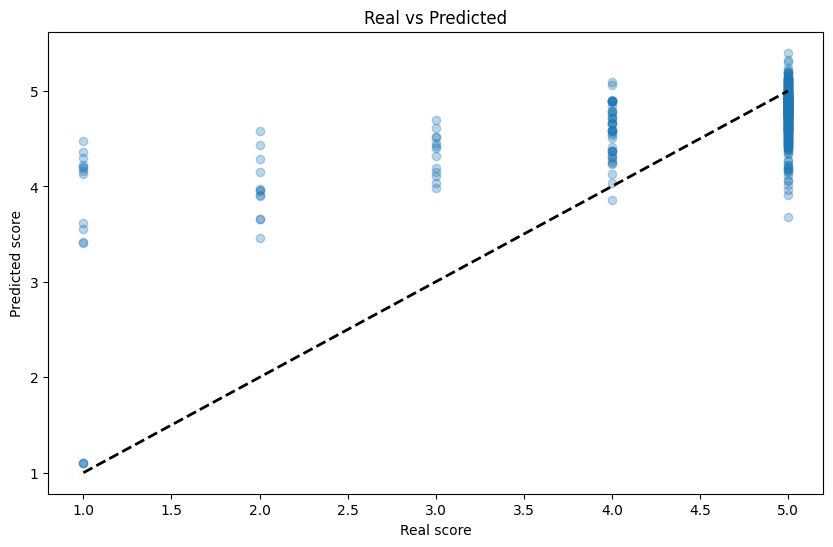

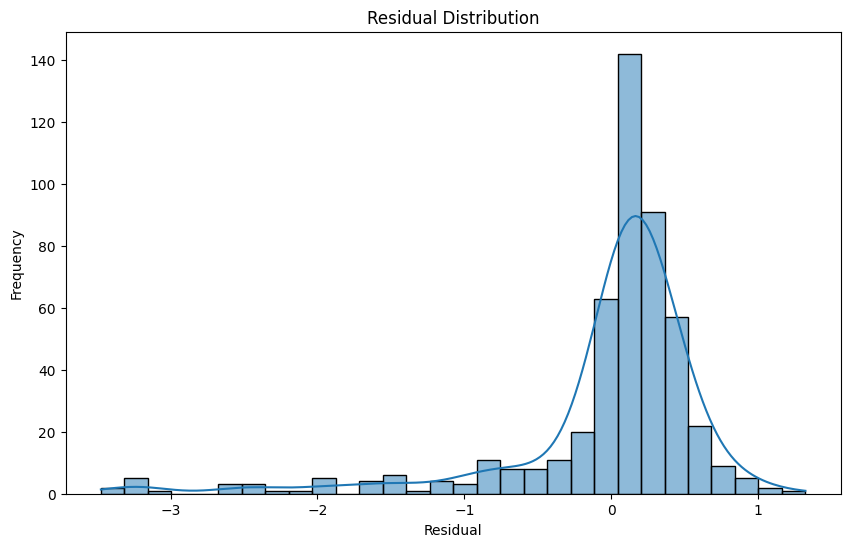

In [48]:
# 시각화: 실제 값과 예측 값 비교
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Real score')
plt.ylabel('Predicted score')
plt.title('Real vs Predicted')
plt.show()

# 잔차 플롯
plt.figure(figsize=(10, 6))
sns.histplot(y_test - y_pred, bins=30, kde=True)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Residual Distribution')
plt.show()

시각화: 실제 값 vs 예측 값 비교

X축 (Real score): 실제 값 (테스트 데이터의 실제 정답)
Y축 (Predicted score): 예측 값 (모델이 예측한 값)
점 (scatter plot): 각 점은 테스트 데이터 한 건을 나타냅니다.
검은 점선 (k--): 이는 실제 값과 예측 값이 완전히 일치하는 경우를 나타냅니다.

해석:
점들이 검은 점선을 중심으로 분포되어 있습니다. 이는 모델이 일반적으로 실제 값에 근접한 값을 예측했다는 것을 나타냅니다.
그러나 일부 점들이 선에서 벗어나 있음을 볼 수 있습니다. 이는 모델이 예측을 부정확하게 한 경우일 수 있습니다.
잔차 플롯

X축 (Residual): 잔차 (실제 값과 예측 값의 차이)
Y축 (Frequency): 잔차의 빈도수

해석:
잔차가 대부분 0을 중심으로 정규분포에 가깝게 분포되어 있습니다. 이는 모델이 일반적으로 정확한 예측을 했다는 것을 의미합니다.
잔차가 큰 경우가 몇 건 있지만, 이는 대부분 저주파 현상으로, 특정 값들이 눈에 띄게 다릅니다

혼돈 행렬

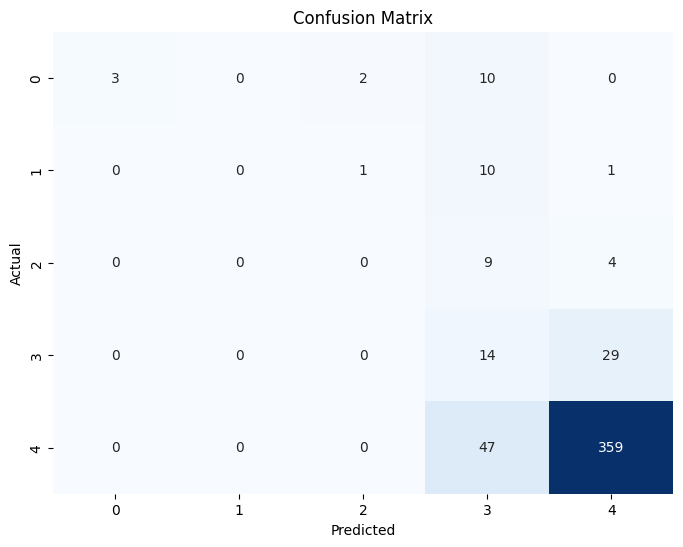

In [53]:
# Confusion Matrix 시각화
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, np.round(y_pred))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

SVR은 회귀 모델로, 다중 클래스 분류를 지원하지 않습니다. 따라서 Precision-Recall Curve를 계산하는 것은 적절하지 않습니다. 대신 SVR 모델을 평가하기 위해 사용할 수 있는 회귀 평가 지표들(MSE, MAE, R²)을 계산하고 시각화하는 방법을 사용

/tmp/ipykernel_1484/1595229816.py:43: UserWarning: Glyph 49892 (\N{HANGUL SYLLABLE SIL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1484/1595229816.py:43: UserWarning: Glyph 51228 (\N{HANGUL SYLLABLE JE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1484/1595229816.py:43: UserWarning: Glyph 44050 (\N{HANGUL SYLLABLE GABS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1484/1595229816.py:43: UserWarning: Glyph 50696 (\N{HANGUL SYLLABLE YE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1484/1595229816.py:43: UserWarning: Glyph 52769 (\N{HANGUL SYLLABLE CEUG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1484/1595229816.py:43: UserWarning: Glyph 47784 (\N{HANGUL SYLLABLE MO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1484/1595229816.py:43: UserWarning: Glyph 45944 (\N{HANGUL SYLLABLE DEL}) missing from font(s) DejaVu Sans.
  plt.tight_la

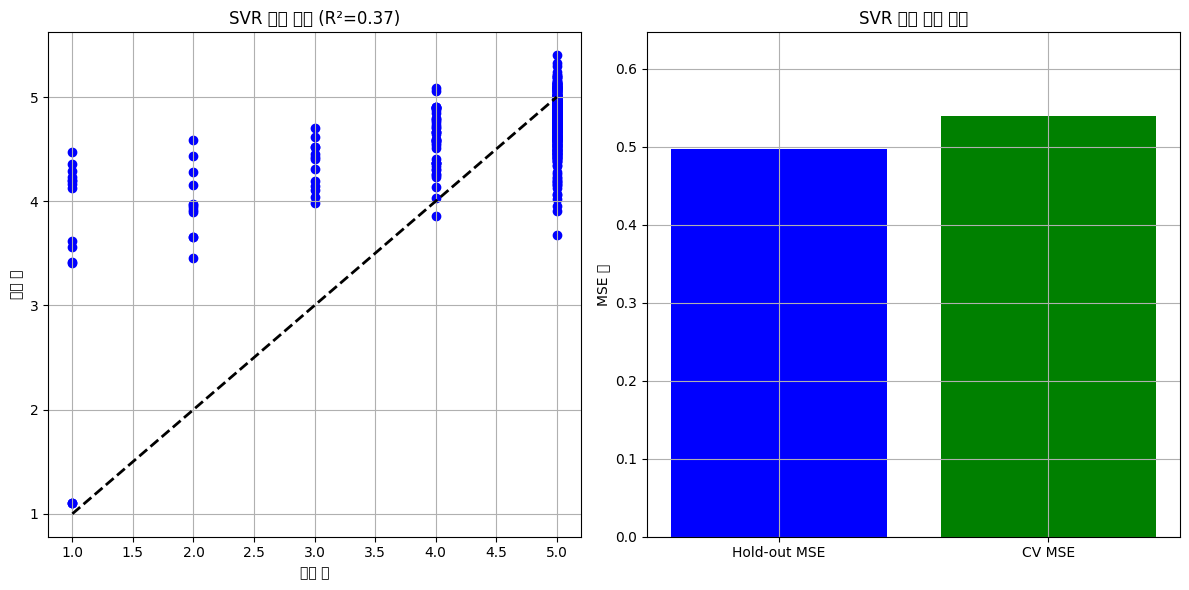

In [58]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('svr', SVR())
])

param_grid = {
    'tfidf__max_df': [0.8, 0.9, 1.0],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'svr__C': [0.1, 1, 10],
    'svr__epsilon': [0.1, 0.2, 0.5]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

# 시각화 부분
# R² 점수와 MSE 값을 시각화합니다.
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# R² 점수 시각화
ax1.scatter(y_test, y_pred, color='blue')
ax1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
ax1.set_xlabel('실제 값')
ax1.set_ylabel('예측 값')
ax1.set_title('SVR 모델 예측 (R²={:.2f})'.format(r2))
ax1.grid()

# MSE 값 시각화
cv_mean_mse = -cv_scores.mean()
ax2.bar(['Hold-out MSE', 'CV MSE'], [mse, cv_mean_mse], color=['blue', 'green'])
ax2.set_ylim(0, max(mse, cv_mean_mse) * 1.2)
ax2.set_ylabel('MSE 값')
ax2.set_title('SVR 모델 성능 평가')
ax2.grid()

plt.tight_layout()
plt.show()
